In [411]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import random

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)

tensor([1.], device='mps:0')


/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [412]:
resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=29 # 26 letters + 3 characters
    ),
    torch.nn.Softmax()
)
resnet50.fc

Sequential(
  (0): Linear(in_features=2048, out_features=29, bias=True)
  (1): Softmax(dim=None)
)

In [413]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)
train_path = path+'/asl_alphabet_train/asl_alphabet_train'
train_path

Path to dataset files: /Users/shreeyachand/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


'/Users/shreeyachand/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'

In [414]:
classes = list('ABCDEFGHIJKLMNOPQRSTUVWYXZ')
classes.append('del')
classes.append('nothing')
classes.append('space')

In [415]:
path_list = []
for i in classes:
    for j in range(3000):
        path_list.append(i+'/'+i+str(j+1)+'.jpg')

In [12]:
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

In [473]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, path_list, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            path_list (list): List of all image paths.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.path_list = path_list
        self.transform = transform

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.path_list[idx])
        image = io.imread(img_name)
        class_name = path_list[idx].split('/')[0]
        sample = {'imshow': image, 'class': torch.tensor(classes.index(class_name)), 'letter': class_name}


        if self.transform:
            sample['image'] = self.transform(sample['imshow'])
            i = random.randint(1,10)
            if i < 8:
                d = random.randint(-30,30)
                sample['image'] = F.rotate(sample['image'], d)
                s = random.randint(100,200)
                zoom = transforms.CenterCrop(size=s) 
                sample['image'] = zoom(sample['image'])
    
                i = random.randint(1,2)
                if i == 1:
                    sample['image'] = torch.flip(sample['image'], [2])
            sample['image'] = transforms.Resize(200)(sample['image'])
            sample['imshow'] = np.asarray(sample['image'])
            sample['imshow'] = np.moveaxis(sample['imshow'], 0, -1)

        return sample

In [418]:
for name, layer in resnet50.named_children():
    if name in ['conv1', 'bn1', 'layer1', 'layer2']:
        for param in layer.parameters():
            param.requires_grad = False

In [419]:
dataset = ASLDataset(root_dir=train_path, path_list=path_list, transform=transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(dataset, [round(.7*len(dataset)), round(.3*len(dataset))])
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

0 torch.Size([3, 200, 200])
1 torch.Size([3, 200, 200])
2 torch.Size([3, 200, 200])
3 torch.Size([3, 200, 200])


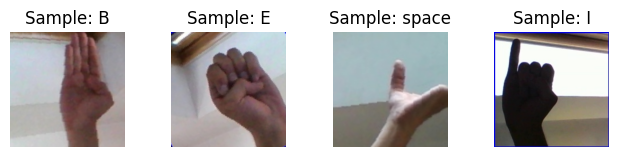

In [653]:
fig = plt.figure()

for i in range(4):
    sample = random.choice(dataset)
    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample: {}'.format(sample['letter']))
    ax.axis('off')
    
    plt.imshow(sample['imshow'])

plt.show()

In [445]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters())
train_losses = []
val_losses = []

In [659]:
num_epochs = 5
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image'].to(device)
        labels = data['class'].to(device)

        # zero the parameter gradients
        resnet50.train()
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs).to(device)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 200 == 0:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            train_losses.append(running_loss / 200)
            running_loss = 0.0

    resnet50.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data['image'].to(device)
            labels = data['class'].to(device)
            outputs = resnet50(inputs).to(device)
            val_loss += loss_function(outputs, labels).item()  # Sum up batch loss

    val_loss /= len(val_loader)  # Calculate average validation loss
    print("val loss for epoch " + str(epoch) + ": " + str(val_loss))
    val_losses.append(val_loss)

print('Finished Training')

/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1,   200] loss: 2.711
[1,   400] loss: 2.718
[1,   600] loss: 2.709
[1,   800] loss: 2.713
[1,  1000] loss: 2.709
[1,  1200] loss: 2.718
[1,  1400] loss: 2.717
[1,  1600] loss: 2.720
[1,  1800] loss: 2.725
val loss for epoch 0: 2.715255396915417
[2,   200] loss: 2.728
[2,   400] loss: 2.719
[2,   600] loss: 2.711
[2,   800] loss: 2.720
[2,  1000] loss: 2.719
[2,  1200] loss: 2.723
[2,  1400] loss: 2.719
[2,  1600] loss: 2.708
[2,  1800] loss: 2.714


KeyboardInterrupt: 

In [658]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [654]:
classes[int(torch.argmax(resnet50(sample['image'].unsqueeze(0))))]

'I'

'I'

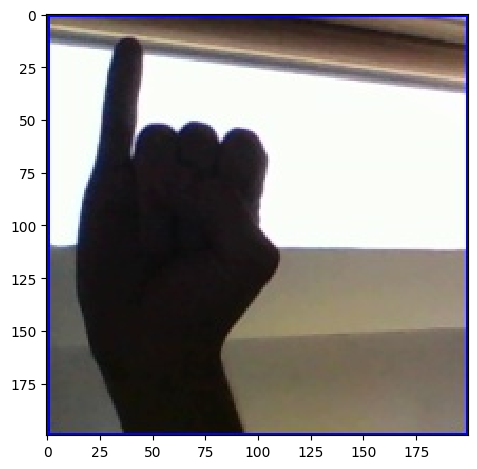

In [655]:
io.imshow(sample['imshow'])
sample['letter']

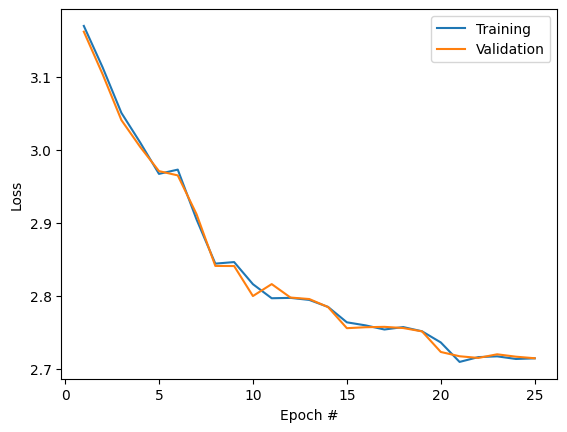

In [657]:
train_losses_plot = []
for i, loss in enumerate(train_losses):
    if (i+1) % 9 == 0:
        train_losses_plot.append(loss)

len(train_losses_plot)
plt.plot(range(1,26),train_losses_plot, label="Training")
plt.plot(range(1,26),val_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

In [647]:
torch.save(resnet50, '25-epochs.pth') 

In [660]:
model = torch.load('25-epochs.pth', weights_only=False)
model.to(device)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images = data['image']
        labels = data['class']
        outputs = resnet50(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
          c = classes[int(label)]
          p = classes[int(prediction)]
          total_pred[c] += 1
          if (c == p):
            correct_pred[c] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/Users/shreeyachand/Downloads/cais-final-asl/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy for class: A     is 98.9 %
Accuracy for class: B     is 98.8 %
Accuracy for class: C     is 99.8 %
Accuracy for class: D     is 0.0 %
Accuracy for class: E     is 0.0 %
Accuracy for class: F     is 0.0 %
Accuracy for class: G     is 98.9 %
Accuracy for class: H     is 98.6 %
Accuracy for class: I     is 98.1 %
Accuracy for class: J     is 98.5 %
Accuracy for class: K     is 0.0 %
Accuracy for class: L     is 0.0 %
Accuracy for class: M     is 96.9 %
Accuracy for class: N     is 96.3 %
Accuracy for class: O     is 99.3 %
Accuracy for class: P     is 99.4 %
Accuracy for class: Q     is 0.0 %
Accuracy for class: R     is 99.4 %
Accuracy for class: S     is 98.8 %
Accuracy for class: T     is 96.5 %
Accuracy for class: U     is 0.0 %
Accuracy for class: V     is 0.0 %
Accuracy for class: W     is 98.5 %
Accuracy for class: Y     is 96.1 %
Accuracy for class: X     is 97.3 %
Accuracy for class: Z     is 97.2 %
Accuracy for class: del   is 99.4 %
Accuracy for class: nothing is 100.0

In [661]:
i = 0
true_labels = []
pred_labels = []
for data in val_loader:
    images = data['image']
    labels = data['class']
    outputs = resnet50(images.to(device))
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        c = classes[int(label)]
        p = classes[int(prediction)]
        true_labels.append(c)
        pred_labels.append(p)
    i += 1
    if i >= 15:
        break

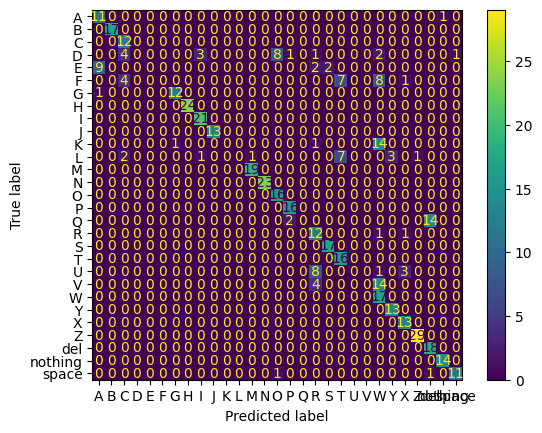

In [662]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(true_labels, pred_labels, labels=classes)
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()